# Image Classification using AWS SageMaker

In this project, we will be using AWS Sagemaker to finetune a pretrained model that can perform image classification. We will have to use Sagemaker profiling, debugger, hyperparameter tuning and other good ML engineering practices.

In [ ]:
!pip install smdebug

In [1]:
import sagemaker

## Dataset
We will use the dog breed classication dataset to classify between different breeds of dogs in image.

In [ ]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

In [2]:
sagemaker_session = sagemaker.Session()

bucket = "my-project-bucket-123"
prefix = "dogImages"
region ="us-east-1" 
role = "arn:aws:iam::450092352571:role/service-role/AmazonSageMaker-ExecutionRole-20211220T094072"

print("Default Bucket: {}".format(bucket))
print("Prefix: {}".format(prefix))
print("AWS Region: {}".format(region))
print("RoleArn: {}".format(role))

Default Bucket: my-project-bucket-123
Prefix: dogImages
AWS Region: us-east-1
RoleArn: arn:aws:iam::450092352571:role/service-role/AmazonSageMaker-ExecutionRole-20211220T094072


In [3]:
import os

os.environ["DEFAULT_S3_BUCKET"] = bucket
!aws s3 sync ./dogImages/train s3://${DEFAULT_S3_BUCKET}/dogImages/train/
!aws s3 sync ./dogImages/test s3://${DEFAULT_S3_BUCKET}/dogImages/test/
!aws s3 sync ./dogImages/valid s3://${DEFAULT_S3_BUCKET}/dogImages/valid/

upload: dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg to s3://my-project-bucket-123/dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg
upload: dogImages/train/001.Affenpinscher/Affenpinscher_00004.jpg to s3://my-project-bucket-123/dogImages/train/001.Affenpinscher/Affenpinscher_00004.jpg
upload: dogImages/train/001.Affenpinscher/Affenpinscher_00010.jpg to s3://my-project-bucket-123/dogImages/train/001.Affenpinscher/Affenpinscher_00010.jpg
upload: dogImages/train/001.Affenpinscher/Affenpinscher_00009.jpg to s3://my-project-bucket-123/dogImages/train/001.Affenpinscher/Affenpinscher_00009.jpg
upload: dogImages/train/001.Affenpinscher/Affenpinscher_00006.jpg to s3://my-project-bucket-123/dogImages/train/001.Affenpinscher/Affenpinscher_00006.jpg
upload: dogImages/train/001.Affenpinscher/Affenpinscher_00002.jpg to s3://my-project-bucket-123/dogImages/train/001.Affenpinscher/Affenpinscher_00002.jpg
upload: dogImages/train/001.Affenpinscher/Affenpinscher_00012.jpg to s3://my

## Hyperparameter Tuning

In [6]:
#TODO: Declare your HP ranges, metrics etc.
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([10, 50, 100, 500, 1000]),
    "epochs": IntegerParameter(2, 4)
}

objective_metric_name = "Testing Accuracy"
objective_type = "Maximize"
metric_definitions = [{"Name": "Testing Accuracy", "Regex": "Testing Accuracy: ([0-9\\.]+)"}]

In [7]:
#TODO: Create estimators for your HPs
from sagemaker.pytorch import PyTorch

# TODO: Your estimator here
estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.large"
)

# TODO: Your HP tuner here
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [9]:
# TODO: Fit your HP Tuner
input_data = "s3://{}/dogImages".format(bucket)
tuner.fit({
'train': input_data+'/train',     
'val': input_data+'/valid',  
'test': input_data+'/test'     
}) # TODO: Remember to include your data channels

.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [10]:
# TODO: Get the best estimators and the best HPs
best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2021-12-23 23:55:48 Starting - Preparing the instances for training
2021-12-23 23:55:48 Downloading - Downloading input data
2021-12-23 23:55:48 Training - Training image download completed. Training in progress.
2021-12-23 23:55:48 Uploading - Uploading generated training model
2021-12-23 23:55:48 Completed - Training job completed


{'_tuning_objective_metric': '"Testing Accuracy"',
 'batch_size': '"7"',
 'epochs': '4',
 'lr': '0.002289006604437888',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2021-12-23-22-44-51-206"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-450092352571/pytorch-training-2021-12-23-22-44-51-206/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging

In [12]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import Rule, ProfilerRule, rule_configs

rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)
debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

import sagemaker
from sagemaker.pytorch import PyTorch

In [11]:
input_data = "s3://{}/dogImages".format(bucket)
print("The input data will be {}".format(input_data))

The input data will be s3://mys3bucket-project/dogImages


In [22]:
lr = float(best_estimator.hyperparameters()["lr"])
epochs = int(best_estimator.hyperparameters()['epochs'])
batch_size = int(best_estimator.hyperparameters()['batch_size'][1:-1])

print(lr)
print(batch_size)
print(epochs)

0.002289006604437888
7
4


In [23]:
hyperparameters = {
    "lr": lr,
    "batch_size": batch_size,
    "epochs": epochs
}

In [24]:
# TODO: Create and fit an estimator
# TODO: Your estimator here
estimator = sagemaker.pytorch.estimator.PyTorch(
    role=role,
    instance_count=1,
    instance_type="ml.m5.large",
    entry_point="train_model.py",
    framework_version="1.8",
    py_version="py36",
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    hyperparameters = hyperparameters,
    rules=rules,
    output_path=input_data
)

In [25]:
estimator.fit({
'train': input_data+'/train',     
'test': input_data+'/test',      
}, wait=True)

2021-12-24 01:16:37 Starting - Starting the training job...
2021-12-24 01:16:50 Starting - Launching requested ML instancesLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2021-12-24 01:18:03 Starting - Preparing the instances for training.........
2021-12-24 01:19:44 Downloading - Downloading input data.........
2021-12-24 01:25:27 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-12-24 01:21:25,336 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2021-12-24 01:21:25,339 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-12-24 01:21:25,347 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups suc

In [26]:
pt_model_data = estimator.model_data
print("Model artifact saved at:\n", pt_model_data)

Model artifact saved at:
 s3://mys3bucket-project/dogImages/pytorch-training-2021-12-24-01-16-36-828/output/model.tar.gz


In [27]:
import boto3

session = boto3.session.Session()
region = session.region_name

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

Training jobname: pytorch-training-2021-12-24-01-16-36-828
Region: us-east-1


In [28]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())
print(trial.tensor_names())
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print("")
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))


[2021-12-23 20:59:21.757 Robeds-MacBook-Air.local:6338 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-12-23 20:59:21.820 Robeds-MacBook-Air.local:6338 INFO s3_trial.py:42] Loading trial debug-output at path s3://mys3bucket-project/dogImages/pytorch-training-2021-12-24-01-16-36-828/debug-output
[2021-12-23 20:59:24.723 Robeds-MacBook-Air.local:6338 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2021-12-23 20:59:25.782 Robeds-MacBook-Air.local:6338 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.1.relu_input_0', 'layer1.1.relu_input_1', 'layer2.0.relu_input_0', 'layer2.0.relu_input_1', 'layer2.1.relu_input_0', 'layer2.1.relu_input_1', 'layer3.0.relu_input_0', 'layer3.0.relu_input_1', 'layer3.1.relu_input_0', 'layer3.1.relu_input_1', 'layer4.0.relu_input_0', 'layer4.0.relu_input_1', 'layer4.1.relu_input_0', 'lay

In [29]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [30]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


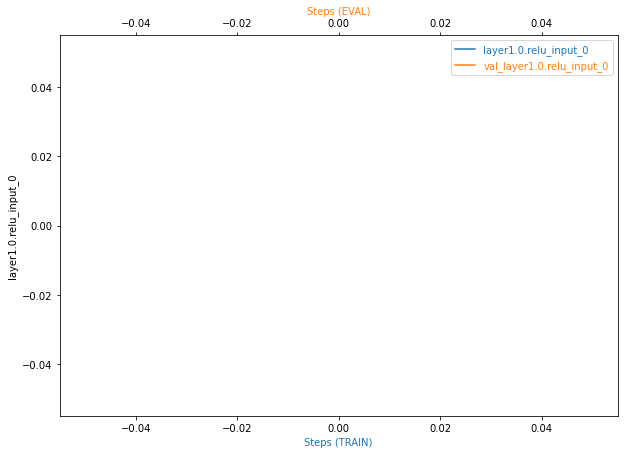

In [41]:
# TODO: Plot a debugging output.
plot_tensor(trial, "layer1.0.relu_input_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [32]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://mys3bucket-project/dogImages', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}}
s3 path:s3://mys3bucket-project/dogImages/pytorch-training-2021-12-24-01-16-36-828/profiler-output


Profiler data from system is available


In [33]:
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

[2021-12-23 21:00:05.308 Robeds-MacBook-Air.local:6338 INFO metrics_reader_base.py:134] Getting 39 event files
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'CPUUtilization-nodeid:algo-1'}


In [34]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://mys3bucket-project/dogImagespytorch-training-2021-12-24-01-16-36-828/rule-output


In [35]:
! aws s3 ls {rule_output_path} --recursive

In [36]:
! aws s3 cp {rule_output_path} ./ --recursive

In [37]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [38]:
# TODO: Display the profiler output
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [39]:
from sagemaker.model_monitor import DataCaptureConfig

data_capture_config = DataCaptureConfig(
    enable_capture=True,
    sampling_percentage=34,
    destination_s3_uri=f"s3://{bucket}/data_capture",
)

In [40]:
# TODO: Deploy your model to an endpoint

predictor=estimator.deploy(instance_type="ml.m5.large", initial_instance_count=1) # TODO: Add your deployment configuration like instance type and number of instances

-------!

In [46]:
# TODO: Run an prediction on the endpoint
# TODO: Your code to load and preprocess image to send to endpoint for prediction
import torch
import torchvision
from torchvision import transforms

testing_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


testset = torchvision.datasets.ImageFolder(root="sample_image", 
            transform=testing_transform)
image = torch.utils.data.DataLoader(testset)
for input, label in image:
    print(predictor.predict(input))


[[10.06587696  0.66527861 -1.17646003 -1.71161211 -4.08161163 -1.91401529
  -2.28166914 -2.52746201  0.17423639 -1.2513119  -1.82251787 -0.25987312
   2.11548305 -2.74935055 -2.83431721 -3.21522617  1.12001836 -1.36757338
  -1.86302555 -1.70229614  0.24482943 -0.23610242 -0.20962775  1.40287268
  -0.91590297  4.17200375 -1.98868632 -1.67554545 -0.09780835  3.8914063
  -2.48529816 -0.12527892  5.09999561  1.64008212  0.63248903  2.44656491
  -2.63880849  7.04961395 -3.14772296  1.91524887  2.22258377  5.13467789
  -1.72701752  1.43028748 -2.42761898  1.23851848 -1.91918409 -0.18450095
   0.42254475 -0.26803353  1.44135177 -0.5788483   1.42165732 -2.00158525
  -1.92392945 -0.14820024 -1.64093399  1.05419111 -1.43162823  0.46423104
  -1.72505021 -0.35932851 -0.65651309  2.75015259 -1.97983575 -0.06645779
  -1.06433749  0.78265119  2.59367347 -0.97108805 -2.60015225 -2.90243292
   1.72388172  3.23061037  2.52344966 -2.05909657  0.32551029 -1.59641933
  -2.04119134 -1.59808433 -2.99726558  

In [47]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()